#  GCNs to classify a graph as a whole.

Graph classification refers to the problem of classifiying entire graphs (in contrast to nodes), given a **dataset of graphs**, based on some structural graph properties.

<div>
<img src="https://drive.google.com/uc?export=view&id=1Yb0xw4Jy7Ytpm91ONMpXFgxNNvH0pw6f" width = 550px height=350px />
</div>


In [40]:
# Install required packages.
!python -c "import torch; print(torch.version.cuda)"!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!python -c "import torch; print(torch.__version__)"

  File "<string>", line 1
    import torch; print(torch.version.cuda)!pip
                                           ^
SyntaxError: invalid syntax
1.7.0+cu101


In [41]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [42]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html


In [43]:
pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html


In [44]:
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 21.5MB 1.5MB/s 


In [45]:
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 6.4MB 6.8MB/s 


In [46]:
!pip install torch-geometric

In [47]:
!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 11.9MB 8.5MB/s 
     |████████████████████████████████| 24.3MB 109kB/s 
  Found existing installation: torch-scatter 2.0.5
    Uninstalling torch-scatter-2.0.5:
      Successfully uninstalled torch-scatter-2.0.5
  Found existing installation: torch-sparse 0.6.8
    Uninstalling torch-sparse-0.6.8:
      Successfully uninstalled torch-sparse-0.6.8


### Dataset

In [48]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset  

In [49]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [50]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


From the [TUM Datasets](https://chrsmrrs.github.io/datasets/docs/datasets/) we 
import the AIDS dataset. This dataset provides **2000 different graphs**, and the task is to classify each graph into **one of two classes**.

By inspecting the first graph object of the dataset, we can see that it comes with **38 nodes (with 38-dimensional feature vectors)** and **106 edges** (leading to an average node degree of 2.26).

It also comes with exactly **one graph label** (`y=[1]`).
<div>
<img src="https://drive.google.com/uc?expot=view&id=1-TOhLzyT5qUJ_fmYaQ7UxvfogavOqGbK" width=500px height=250px/>
<div/>

In [51]:
torch.manual_seed(12345)    # reproducability 
dataset = dataset.shuffle() # suffling

train_dataset = dataset[:int(len(dataset)*0.8)]  # 80% training
test_dataset = dataset[int(len(dataset)*0.8):]   # 20% testing

In [52]:
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


### Mini-batching of graphs



Since graphs in graph classification datasets are usually small, a good idea is to **batch the graphs** before inputting them into a Graph Neural Network to guarantee full GPU utilization.
In the image or language domain, this procedure is typically achieved by **rescaling** or **padding** each example into a set of equally-sized shapes, and examples are then grouped in an additional dimension.
The length of this dimension is then equal to the number of examples grouped in a mini-batch and is typically referred to as the `batch_size`.

However, for GNNs the two approaches described above are either not feasible or may result in a lot of unnecessary memory consumption.
Therefore, PyTorch Geometric opts for another approach to achieve parallelization across a number of examples. Here, adjacency matrices are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target features are simply concatenated in the node dimension:


<div>
<img src="https://drive.google.com/uc?export=view&id=13IcgkLCZ6FleauksMAiiVXlQFSqhGcP4" />
</div>


This procedure has some crucial advantages over other batching procedures:

1. GNN operators that rely on a message passing scheme do not need to be modified since messages are not exchanged between two nodes that belong to different graphs.

2. There is no computational or memory overhead since adjacency matrices are saved in a sparse fashion holding only non-zero entries, *i.e.*, the edges.

PyTorch Geometric automatically takes care of **batching multiple graphs into a single giant graph** with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class:


In [61]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=19, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 30
Batch(batch=[507], edge_attr=[1108, 4], edge_index=[2, 1108], x=[507, 7], y=[30])

Step 2:
Number of graphs in the current batch: 30
Batch(batch=[532], edge_attr=[1172, 4], edge_index=[2, 1172], x=[532, 7], y=[30])

Step 3:
Number of graphs in the current batch: 30
Batch(batch=[549], edge_attr=[1220, 4], edge_index=[2, 1220], x=[549, 7], y=[30])

Step 4:
Number of graphs in the current batch: 30
Batch(batch=[572], edge_attr=[1272, 4], edge_index=[2, 1272], x=[572, 7], y=[30])

Step 5:
Number of graphs in the current batch: 30
Batch(batch=[554], edge_attr=[1222, 4], edge_index=[2, 1222], x=[554, 7], y=[30])



Furthermore, each `Batch` object is equipped with a **`batch` vector**, which maps each node to its respective graph in the batch:

$$
\textrm{batch} = [ 0, \ldots, 0, 1, \ldots, 1, 2, \ldots ]
$$

### Training a Graph Convolution Neural Network (GCNConv)



Training a GCN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

In [62]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

p_dropout =  0.2 #dropout 
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=p_dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=p_dropout, training=self.training)

        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=p_dropout, training=self.training)
        x = self.lin(x)
        x = F.softmax(x, dim=1)

        return x


[global_mean_pooling](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool): 

Returns batch-wise graph-level-outputs by averaging node features across the node 
<br>
dimension, so that for a single graph $G_i$  its output is 
computed by: 
<br>
$ r_i =\frac{1}{N_i} \sum_{n=1}^{N_i} x_n $



> PARAMETERS

- x (Tensor) - Node feature matrix **X**$\in \mathbb{R} ^{(N_1+..+N_B)xF}$
- batch ( long tensor) - Batch vector **b** $\in {0,.., B-1}^N$, which assigns each node to a specific example (graph).
- size (int, optional) - Batch size B. Automatically calculated if not given.

<div>
<img src="https://drive.google.com/uc?export=view&id=1AjxGAurUAwOdgQD0oHud9Q3JFzdzYfHP" />
</div>

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(hidden_channels=64).to(device)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [64]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [65]:

losses = []
acc_test = []
for epoch in range(0,201):
  model.train()
  optimizer.zero_grad()
  temp = []
  for data in train_loader:                              # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)                     # Compute the loss.
        loss.backward()                                   # Derive gradients.
        optimizer.step()                                  # Update parameters based on gradients.
        optimizer.zero_grad()                             # Clear gradients.
        temp.append(loss)
  
  losses.append( sum(temp)/ len(temp))

  model.eval()
  correct = 0
  
  for data in test_loader:  # Iterate in batches over the training/test dataset.
      data.to(device)
      out = model(data.x, data.edge_index, data.batch)  
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct += int((pred == data.y).sum())  # Check against ground-truth labels.
  
  acc = (correct / len(test_loader.dataset))  # Derive ratio of correct predictions.
  acc_test.append(acc)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch:03d}, Loss: {losses[epoch]:.4f}, Test Acc: {acc_test[epoch]:.4f}')



        

Epoch: 000, Loss: 0.6616, Test Acc: 0.7368
Epoch: 010, Loss: 0.5838, Test Acc: 0.7632
Epoch: 020, Loss: 0.5430, Test Acc: 0.7368
Epoch: 030, Loss: 0.5421, Test Acc: 0.7368
Epoch: 040, Loss: 0.5537, Test Acc: 0.7368
Epoch: 050, Loss: 0.5507, Test Acc: 0.7368
Epoch: 060, Loss: 0.5639, Test Acc: 0.7632
Epoch: 070, Loss: 0.5273, Test Acc: 0.7368
Epoch: 080, Loss: 0.5722, Test Acc: 0.7368
Epoch: 090, Loss: 0.5379, Test Acc: 0.7632
Epoch: 100, Loss: 0.5276, Test Acc: 0.7895
Epoch: 110, Loss: 0.5332, Test Acc: 0.8158
Epoch: 120, Loss: 0.5170, Test Acc: 0.7105
Epoch: 130, Loss: 0.5235, Test Acc: 0.7368
Epoch: 140, Loss: 0.5174, Test Acc: 0.7368
Epoch: 150, Loss: 0.5167, Test Acc: 0.7632
Epoch: 160, Loss: 0.5132, Test Acc: 0.7895
Epoch: 170, Loss: 0.5140, Test Acc: 0.7105
Epoch: 180, Loss: 0.5132, Test Acc: 0.7895
Epoch: 190, Loss: 0.5157, Test Acc: 0.7632
Epoch: 200, Loss: 0.5095, Test Acc: 0.7368


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


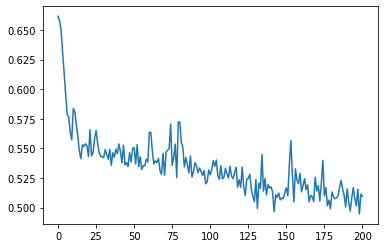

In [66]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [67]:
import pandas as pd 

# Analyze the results for one batch
with torch.no_grad():
    data.to(device)
    pred = model(data.x, data.edge_index, data.batch)   
    pred = out.argmax(dim=1)
    df = pd.DataFrame()
    df["y_real"] = data.y.tolist()
    df["y_pred"] = pred.tolist()
df

,y_real,y_pred
0,1,0
1,1,0
2,1,0
3,0,0
4,1,1
5,0,0
6,1,0
7,1,1
8,1,0
9,1,1


In [68]:
# last test batch
data

Batch(batch=[341], edge_attr=[750, 4], edge_index=[2, 750], x=[341, 7], y=[19])